## Sommaire

1. [Chargement et préparation des données](#chargement-et-préparation-des-données)
2. [Dépendance brute entre résultats consécutifs](#dépendance-brute-entre-résultats-consécutifs)
3. [L’effet Hot Hand dépend-il du format de partie ?](#leffet-hot-hand-dépend-il-du-format-de-partie)
4. [Analyse par niveau de jeu (rating)](#analyse-par-niveau-de-jeu-rating)
5. [Proximité temporelle et sessions de jeu](#proximité-temporelle-et-sessions-de-jeu)
6. [Contrôler les biais : régression logistique](#contrôler-les-biais--régression-logistique)
7. [Les séries observées dépassent-elles le hasard ?](#les-séries-observées-dépassent-elles-le-hasard)
8. [Analyses complémentaires](#analyses-complémentaires)
9. [Conclusion](#conclusion)


> 💡 **Note de lecture**  
> Le notebook peut être lu sans exécuter l’ensemble des cellules. Les résultats principaux sont commentés directement sous chaque graphique ou tableau.

# Chargement et concaténation des données S3

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
import s3fs

In [97]:
BUCKET_NAME = "tristant"
S3_PREFIX = "diffusion"
S3_ENDPOINT = os.getenv("minio.lab.sspcloud.fr")
S3_ENDPOINT = os.getenv("AWS_S3_ENDPOINT", "minio.lab.sspcloud.fr")

storage_options = {
    "client_kwargs": {"endpoint_url": S3_URL}
}

In [ ]:
# --- 1. CONFIGURATION S3  ---
BUCKET_NAME = "tristant"
S3_PREFIX = "diffusion"

S3_ENDPOINT = os.getenv("AWS_S3_ENDPOINT", "minio.lab.sspcloud.fr")
S3_URL = f"https://{S3_ENDPOINT}"

print(f"🔗 Connexion S3 établie vers : {S3_URL}")

storage_options = {
    "client_kwargs": {"endpoint_url": S3_URL}
}

# --- 2. CHARGEMENT ---
file_to_load = "dfs_games.parquet"
s3_path = f"s3://{BUCKET_NAME}/{S3_PREFIX}/{file_to_load}"

try:
    print(f"📥 Téléchargement de {s3_path}...")
    df_all = pd.read_parquet(s3_path, storage_options=storage_options)
    print(f"✅ Succès ! {len(df_all)} parties chargées.")
    
    # Aperçu rapide
    print(df_all.head())

except Exception as e:
    print(f"❌ Erreur de chargement : {e}")
    df_all = pd.DataFrame() # Vide en cas d'erreur pour ne pas planter la suite

🔗 Connexion S3 établie vers : https://minio.lab.sspcloud.fr
📥 Téléchargement de s3://tristant/diffusion/dfs_games.parquet...
✅ Succès ! 35630 parties chargées.
      user_id   game_id format_partie   timestamp_ms result  eco  \
0  withnail77  pTjbf44T        bullet  1681836904282   Loss  B10   
1  withnail77  aYfkh89b        bullet  1671800191224    Win  C23   
2  withnail77  3b8Sp5YW        bullet  1671786674851   Loss  C21   
3  withnail77  klbLKVzB        bullet  1651832391509   Loss  D00   
4  withnail77  x6smqOwo        bullet  1642175967066   Loss  C70   

                opening_name  rating  rating_diff  color  
0          Caro-Kann Defense    1018        -59.0  white  
1           Bishop's Opening     943         75.0  white  
2                Center Game    1010        -67.0  black  
3          Queen's Pawn Game    1073        -63.0  black  
4  Ruy Lopez, Morphy Defense    1142        -69.0  white  


# Remise en forme du dataframe

In [99]:
# --- CORRECTION CRITIQUE DES DOUBLONS ---
# On supprime les lignes qui ont exactement le même ID de partie (game_id)
# ou à défaut le même user + timestamp
print(f"Nombre de lignes AVANT dédoublonnage : {len(df_all)}")

if "game_id" in df_all.columns:
    df_all = df_all.drop_duplicates(subset=["user_id", "game_id"]).copy()
else:
    # Si game_id n'est pas là, on utilise le timestamp comme signature unique
    df_all = df_all.drop_duplicates(subset=["user_id", "timestamp"]).copy()

print(f"Nombre de lignes APRÈS dédoublonnage : {len(df_all)}")

Nombre de lignes AVANT dédoublonnage : 35630
Nombre de lignes APRÈS dédoublonnage : 35630


In [100]:
# --- CORRECTION COMPATIBILITÉ ---
if "timestamp" not in df_all.columns:
    df_all["timestamp"] = df_all["timestamp_ms"]

# 1️⃣ Trier par joueur et par temps
df_all = df_all.sort_values(["user_id", "timestamp"]).reset_index(drop=True)

# 2️⃣ NETTOYAGE DES DRAWS (NOUVEAU)
# On retire les parties nulles pour ne pas fausser les stats victoire/défaite
# (Sinon un nul est compté comme une défaite par le .astype(int))
print(f"Nombre de parties avant nettoyage des nuls : {len(df_all)}")
df_all = df_all[df_all["result"] != "Draw"].copy()
print(f"Nombre de parties après nettoyage : {len(df_all)}")

# 3️⃣ Créer la colonne binaire win
# Maintenant que les draws sont partis, tout ce qui n'est pas Win est une vraie défaite
df_all["win"] = (df_all["result"] == "Win").astype(int)

# 4️⃣ Créer la colonne win_next par joueur
# On recalcule bien le shift APRÈS avoir enlevé les nuls
df_all["win_next"] = df_all.groupby("user_id")["win"].shift(-1)

# 5️⃣ Vérification
cols_to_show = ["timestamp", "result", "win", "win_next"]
print(df_all[cols_to_show].head(10))

Nombre de parties avant nettoyage des nuls : 35630
Nombre de parties après nettoyage : 34428
       timestamp result  win  win_next
0  1607268853250   Loss    0       0.0
1  1627084923053   Loss    0       0.0
2  1650920550791   Loss    0       1.0
3  1693680426180    Win    1       0.0
4  1693680471979   Loss    0       0.0
5  1693680511386   Loss    0       0.0
6  1693680590808   Loss    0       1.0
7  1693680674621    Win    1       0.0
8  1693680748215   Loss    0       0.0
9  1693680854873   Loss    0       0.0


On fait un shift(-1) car les parties les plus anciennes sont en haut du tableau. Un 1 en colonne Win_next veut dire que le joueur gagne la partie d'après (en comptant vers le bas).

In [ ]:
# Filtrer les lignes où win_next est défini
df_valid = df_all.dropna(subset=["win_next"])

# Créer la table de contingence
transition_table = pd.crosstab(df_valid["win"], df_valid["win_next"])

# Ajouter les probabilités conditionnelles
transition_probs = transition_table.div(transition_table.sum(axis=1), axis=0)

print("Matrice de transition (counts) :")
print(transition_table)

print("\nMatrice de transition (probabilités) :")
print(transition_probs)


Matrice de transition (counts) :
win_next   0.0   1.0
win                 
0         9903  8169
1         8132  7924

Matrice de transition (probabilités) :
win_next       0.0       1.0
win                         
0         0.547975  0.452025
1         0.506477  0.493523


On remarque que la somme sur les lignes donne bien 1 : il y a une cohérence des résultats : lorsque la partie est perdue (ligne win = 0), alors proba(Win N+1) + proba(Lose N+1) = 1.

In [102]:
correlation = df_all[["win","win_next"]].dropna().corr().iloc[0,1]
print("Corrélation Win N → Win N+1 :", correlation)

Corrélation Win N → Win N+1 : 0.04149220329286996


La corrélation entre une victoire et la suivante est légèrement positive.

In [ ]:
table = pd.crosstab(df_all["win"], df_all["win_next"])
chi2, p_value, _, _ = chi2_contingency(table)

print("p-value test χ² :", p_value)

p-value test χ² : 1.943536816565054e-14


Un test statistique de l'hypothèse de dépendance entre victoire N et victoire N-1 est extrêmement significatif. Cela peut s'expliquer par le fait que les joueurs tendent à rejouer avec leurs adversaires à la suite d'une victoire / défaite. Or le différentiel de niveau perdure, d'où le très fort degré de rejet de la situation d'indépendance. Cela ne veut à ce stade pas forcément dire qu'il y a un phénomène de Hot Hand. 

# Analyse par format de parties

In [104]:
df_all.groupby("format_partie").apply(
    lambda x: x.groupby("win")["win_next"].mean()
)

/tmp/ipykernel_25940/3339415686.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all.groupby("format_partie").apply(


win,0,1
format_partie,,
blitz,0.475278,0.496556
bullet,0.405746,0.485799
classical,0.434576,0.505245
rapid,0.456332,0.491219


C'est normal que la somme des lignes ne fasse pas 1 car on a colonne 2 : P(gagner après une défaite) et colonne 3 : P(gagner après une victoire). Le point de départ n'est donc pas le même.

In [ ]:
# Filtrer les lignes valides (win_next non NaN)
df_valid = df_all.dropna(subset=["win_next"])

# Fonction pour calculer p-value χ² pour un sous-DataFrame
def chi2_pvalue(sub_df):
    table = pd.crosstab(sub_df["win"], sub_df["win_next"])
    if table.shape == (2,2):
        _, p_value, _, _ = chi2_contingency(table)
        return p_value
    else:
        return None  # si pas assez de données pour le test

# Calcul des p-values par format de partie
p_values_by_format = df_valid.groupby("format_partie").apply(chi2_pvalue)

print("Voici un tableau récapitulatif des p_values par", p_values_by_format)


Voici un tableau récapitulatif des p_values par format_partie
blitz        1.312755e-02
bullet       2.338387e-10
classical    6.087753e-04
rapid        1.861755e-04
dtype: float64


/tmp/ipykernel_25940/705219268.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  p_values_by_format = df_valid.groupby("format_partie").apply(chi2_pvalue)


Même quand on affine la lecture (selon les types de parties) : l'analyse permet de réfuter avec quasi-certitude l'hypothèse d'indépendance entre résultat du match N et du match N+1. Le résultat est d'autant plus significatif pour les parties "courtes" de type bullet.

Ce qui est cohérent avec l'intuition : ces parties courtes sont susceptibles d'être influencés par des facteurs psychologiques de confiance en soi puisqu'elles sont souvent faites à la suite les unes des autres (cf partie de l'analyse avec affinement pour tenir compte de la proximité temporelle).

# Analyse par tranche de rating

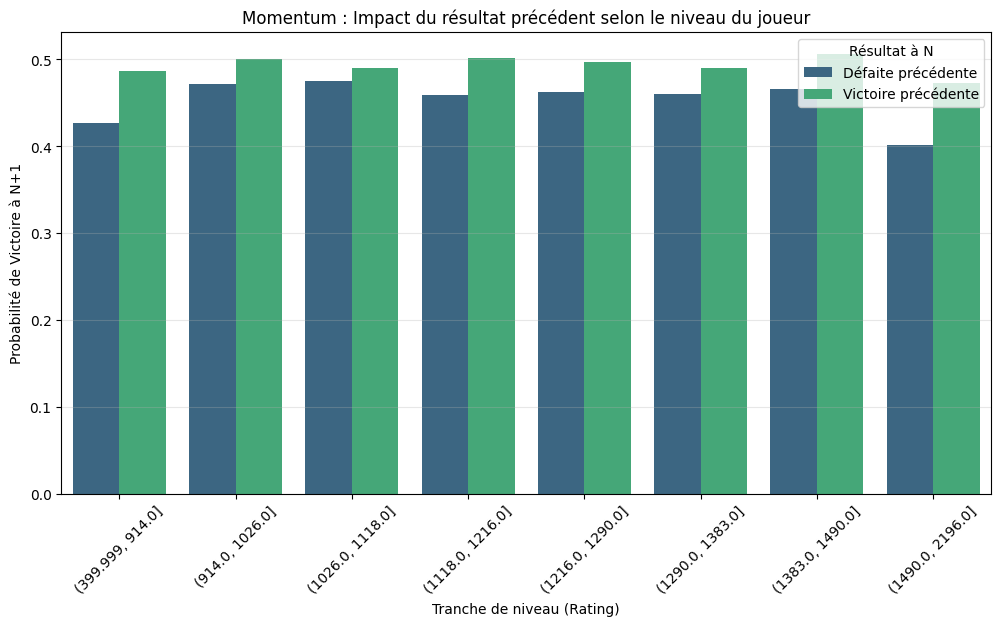

In [ ]:
# --- Création des tranches de niveau ---
# duplicates='drop' gère le cas où trop de joueurs auraient exactement le même Elo
df_all['rating_bin'] = pd.qcut(df_all['rating'], q=8, duplicates='drop')

# Calcul des moyennes par tranche
df_plot = (
    df_all.dropna(subset=["win_next"])
          .groupby(["rating_bin", "win"], observed=True)["win_next"]
          .mean()
          .reset_index()
)

df_plot["win_label"] = df_plot["win"].map({0: "Défaite précédente", 1: "Victoire précédente"})

plt.figure(figsize=(12, 6))
sns.barplot(x="rating_bin", y="win_next", hue="win_label", data=df_plot, palette="viridis")

plt.ylabel("Probabilité de Victoire à N+1")
plt.xlabel("Tranche de niveau (Rating)")
plt.title("Momentum : Impact du résultat précédent selon le niveau du joueur")
plt.xticks(rotation=45)
plt.legend(title="Résultat à N")
plt.grid(axis='y', alpha=0.3)
plt.show()

Même au sein des différents niveau de rating couverts, il semble que l'indépendance puisse être uniformément rejetée.

In [107]:
# 1. Sécurité : On s'assure que la colonne 'date' existe
if 'date' not in df_all.columns:
    # On utilise 'timestamp' ou 'timestamp_ms' selon ce qui est dispo
    col_ref = 'timestamp_ms' if 'timestamp_ms' in df_all.columns else 'timestamp'
    df_all['date'] = pd.to_datetime(df_all[col_ref], unit='ms', utc=True)

# 2. Sélection du joueur test
user_test = df_all['user_id'].iloc[0]
cols_debug = ['user_id', 'date', 'result', 'rating', 'rating_diff', 'win', 'win_next']

print(f"--- Inspection des données pour {user_test} ---")
# On vérifie que toutes les colonnes de debug existent bien
cols_present = [c for c in cols_debug if c in df_all.columns]
print(df_all[df_all['user_id'] == user_test][cols_present].head(15))

print("\n--- Analyse des séries (Indices de Rematch) ---")
# On regarde l'enchaînement des résultats et des écarts de points
print(df_all[df_all['user_id'] == user_test][['result', 'rating_diff']].head(15))

--- Inspection des données pour a13j4ndr0d1390 ---
           user_id                             date result  rating  \
0   a13j4ndr0d1390 2020-12-06 15:34:13.250000+00:00   Loss    1500   
1   a13j4ndr0d1390 2021-07-24 00:02:03.053000+00:00   Loss    1172   
2   a13j4ndr0d1390 2022-04-25 21:02:30.791000+00:00   Loss    1500   
3   a13j4ndr0d1390 2023-09-02 18:47:06.180000+00:00    Win    1919   
4   a13j4ndr0d1390 2023-09-02 18:47:51.979000+00:00   Loss    1926   
5   a13j4ndr0d1390 2023-09-02 18:48:31.386000+00:00   Loss    1920   
6   a13j4ndr0d1390 2023-09-02 18:49:50.808000+00:00   Loss    1910   
7   a13j4ndr0d1390 2023-09-02 18:51:14.621000+00:00    Win    1899   
8   a13j4ndr0d1390 2023-09-02 18:52:28.215000+00:00   Loss    1910   
9   a13j4ndr0d1390 2023-09-02 18:54:14.873000+00:00   Loss    1901   
10  a13j4ndr0d1390 2023-09-02 18:55:20.575000+00:00   Loss    1898   
11  a13j4ndr0d1390 2023-09-02 19:23:04.974000+00:00    Win    1893   
12  a13j4ndr0d1390 2023-09-02 19:24:35.

# Analyse Markov

Création des variables d'analyse (Fatigue, Couleur, Historique)...


/tmp/ipykernel_25940/1201351252.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="is_white", y="win", data=df_all, ax=axes[0], palette="coolwarm", errorbar=None)
/tmp/ipykernel_25940/1201351252.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Noirs", "Blancs"])


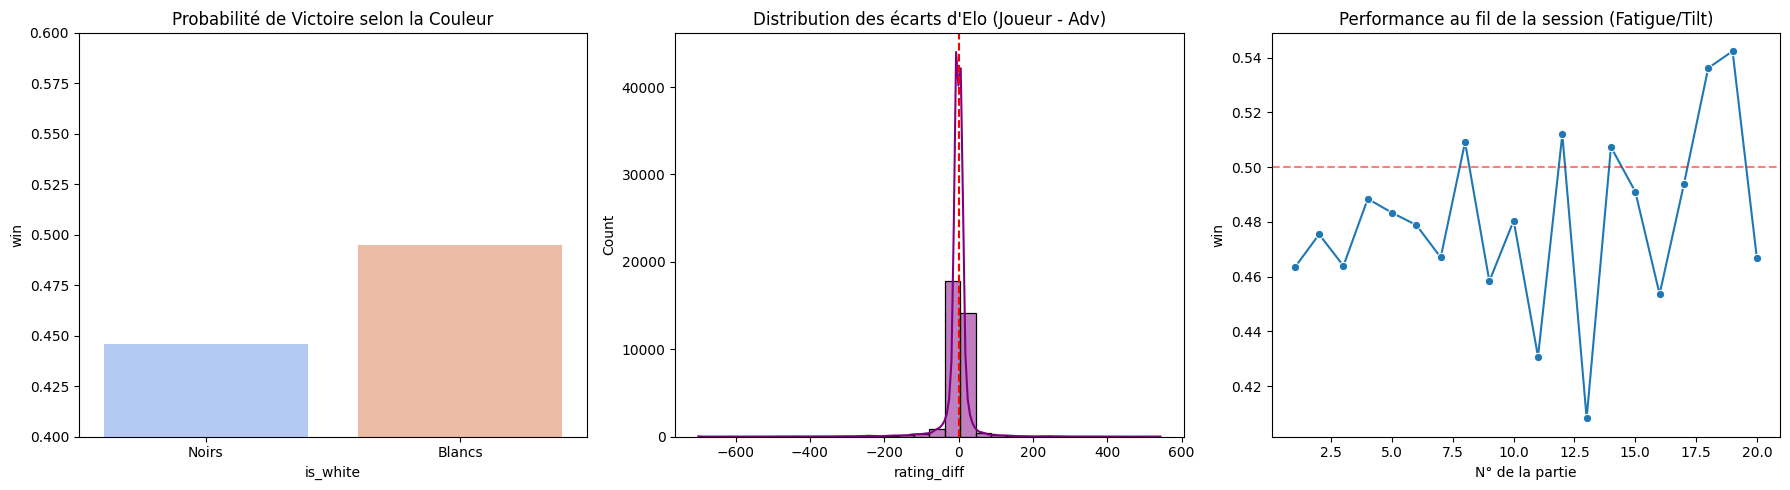


=== CHAÎNES DE MARKOV : EFFET MÉMOIRE ===


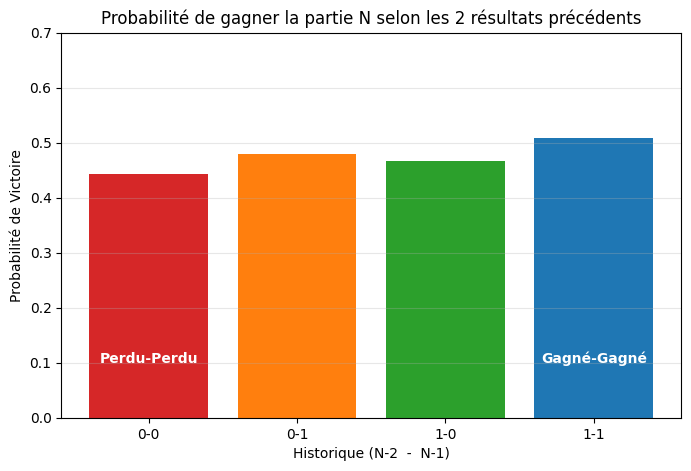

Lecture : Si la barre de droite (1-1) est plus haute que les autres, le 'Hot Hand' s'accumule.


In [ ]:
# --- 1. PRÉPARATION DES VARIABLES ADDITIONNELLES ---
print("Création des variables d'analyse (Fatigue, Couleur, Historique)...")
df_all = df_all.sort_values(['user_id', 'timestamp'])

# a) Résultat précédent (N-1) et (N-2)
df_all['win_prev'] = df_all.groupby('user_id')['win'].shift(1)
df_all['win_prev_2'] = df_all.groupby('user_id')['win'].shift(2)

# b) Couleur (Blancs = 1)
if 'color' in df_all.columns:
    df_all['is_white'] = (df_all['color'] == 'white').astype(int)
else:
    df_all['is_white'] = np.nan

# c) Fatigue / Session de jeu
# On considère une nouvelle session si > 30 min de pause
df_all['time_diff'] = df_all.groupby('user_id')['timestamp'].diff() / (1000 * 60) # minutes
df_all['new_session'] = (df_all['time_diff'] > 30) | (df_all['time_diff'].isna())
df_all['session_id'] = df_all.groupby('user_id')['new_session'].cumsum()
df_all['game_in_session'] = df_all.groupby(['user_id', 'session_id']).cumcount() + 1


# --- 2. VISUALISATIONS DESCRIPTIVES ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Graph A : Avantage des Blancs
if df_all['is_white'].notna().any():
    sns.barplot(x="is_white", y="win", data=df_all, ax=axes[0], palette="coolwarm", errorbar=None)
    axes[0].set_xticklabels(["Noirs", "Blancs"])
    axes[0].set_title("Probabilité de Victoire selon la Couleur")
    axes[0].set_ylim(0.4, 0.6)

# Graph B : Distribution des écarts Elo
if "rating_diff" in df_all.columns:
    sns.histplot(df_all["rating_diff"], bins=30, kde=True, ax=axes[1], color="purple")
    axes[1].set_title("Distribution des écarts d'Elo (Joueur - Adv)")
    axes[1].axvline(0, color='red', linestyle='--')

# Graph C : Fatigue (Win rate selon le n° de partie dans la session)
# On regarde les sessions longues (>10 parties)
long_sessions = df_all[df_all['game_in_session'] <= 20]
sns.lineplot(x="game_in_session", y="win", data=long_sessions, ax=axes[2], marker="o", errorbar=None)
axes[2].set_title("Performance au fil de la session (Fatigue/Tilt)")
axes[2].set_xlabel("N° de la partie")
axes[2].axhline(0.5, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# --- 3. ANALYSE MARKOVIENNE (ORDRE 2) ---
print("\n=== CHAÎNES DE MARKOV : EFFET MÉMOIRE ===")
# On regarde l'impact de l'historique (N-2, N-1) sur la partie N
df_markov = df_all.dropna(subset=['win_prev_2', 'win_prev', 'win']).copy()
df_markov['etat_passe'] = (
    df_markov['win_prev_2'].astype(int).astype(str) + "-" + 
    df_markov['win_prev'].astype(int).astype(str)
)

probs_ordre2 = df_markov.groupby('etat_passe')['win'].mean().sort_index()

plt.figure(figsize=(8, 5))
bars = plt.bar(probs_ordre2.index, probs_ordre2.values, color=['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4'])
plt.title("Probabilité de gagner la partie N selon les 2 résultats précédents")
plt.xlabel("Historique (N-2  -  N-1)")
plt.ylabel("Probabilité de Victoire")
plt.ylim(0, 0.7)
plt.grid(axis='y', alpha=0.3)

# Légende pour comprendre
plt.text(0, 0.1, "Perdu-Perdu", ha='center', color='white', fontweight='bold')
plt.text(3, 0.1, "Gagné-Gagné", ha='center', color='white', fontweight='bold')

plt.show()
print("Lecture : Si la barre de droite (1-1) est plus haute que les autres, le 'Hot Hand' s'accumule.")

# Un joueur qui gagne refait-il la même ouverture ?

In [ ]:
# --- 1️. Créer la colonne "same_opening_next" ---
df_all = df_all.sort_values(["user_id", "timestamp"]).reset_index(drop=True)
df_all["same_opening_next"] = (
    df_all.groupby("user_id")["opening_name"].shift(-1) == df_all["opening_name"]
).astype(int)

# Filtrer lignes valides (où on peut calculer next opening)
df_valid = df_all.dropna(subset=["same_opening_next"])

# --- 2️. Probabilités globales ---
prob_same_by_result = df_valid.groupby("win")["same_opening_next"].mean()
print("Probabilité de rejouer la même ouverture selon résultat N :")
print(prob_same_by_result)

# --- 3️. Test χ² global ---
table_global = pd.crosstab(df_valid["win"], df_valid["same_opening_next"])
chi2, p_value, _, _ = chi2_contingency(table_global)
print("\nTest χ² global :")
print(table_global)
print("p-value :", p_value)

# --- 4️. Analyse par type de partie ---
results_by_format = {}
for fmt, df_fmt in df_valid.groupby("format_partie"):
    table_fmt = pd.crosstab(df_fmt["win"], df_fmt["same_opening_next"])
    if table_fmt.shape == (2,2):
        chi2, p, _, _ = chi2_contingency(table_fmt)
        prob_fmt = df_fmt.groupby("win")["same_opening_next"].mean()
        results_by_format[fmt] = {
            "table": table_fmt,
            "probabilities": prob_fmt,
            "p_value": p
        }

# Afficher les résultats par format
for fmt, res in results_by_format.items():
    print(f"\nFormat : {fmt}")
    print("Table de contingence :\n", res["table"])
    print("Probabilités :", res["probabilities"].to_dict())
    print("p-value :", res["p_value"])

Probabilité de rejouer la même ouverture selon résultat N :
win
0    0.133629
1    0.146625
Name: same_opening_next, dtype: float64

Test χ² global :
same_opening_next      0     1
win                           
0                  15800  2437
1                  13817  2374
p-value : 0.0005492451867909473

Format : blitz
Table de contingence :
 same_opening_next     0    1
win                         
0                  6257  961
1                  5829  943
Probabilités : {0: 0.13313937378775284, 1: 0.13924985233313644}
p-value : 0.3036256684417361

Format : bullet
Table de contingence :
 same_opening_next     0    1
win                         
0                  3179  481
1                  2283  433
Probabilités : {0: 0.13142076502732242, 1: 0.15942562592047127}
p-value : 0.0018126027109408374

Format : classical
Table de contingence :
 same_opening_next     0    1
win                         
0                  1103  160
1                   983  162
Probabilités : {0: 0.12668250197

On remarque que la p-value du test "Il y a dépendance entre gain à la partie N et ouverture rejouée en N+1" est plus significative pour les parties courtes, signe que les joueurs joue davantage à l'instinct.

# Retraitement de l'analyse principale 
On cherche à n'étudier que des streaks de parties qui se suivent réellement (c'est-à-dire pas seulement des parties consécutives - et potentiellement espacées de plusieurs jours-, mais rapprochées dans le temps).

In [ ]:
# S'assurer que timestamp est en datetime
df_all["date"] = pd.to_datetime(df_all["timestamp"], unit='ms')

# Trier par joueur et date
df_all = df_all.sort_values(["user_id", "date"]).reset_index(drop=True)

# Calculer delta_hours entre parties consécutives
df_all["delta_hours"] = df_all.groupby("user_id")["date"].diff().dt.total_seconds() / 3600

# Fonction pour calculer les streaks avec durée maximale paramétrable et format_partie
def streaks_with_time_by_format(df, max_gap_hours):
    streaks = []
    if df.empty:
        return streaks
    
    prev_win = df.iloc[0]["win"]
    prev_time = df.iloc[0]["date"]
    prev_format = df.iloc[0]["format_partie"]
    count = 1
    
    for idx, row in df.iloc[1:].iterrows():
        delta = (row["date"] - prev_time).total_seconds() / 3600
        if (row["win"] == prev_win) and (delta <= max_gap_hours) and (row["format_partie"] == prev_format):
            count += 1
        else:
            if count >= 2:
                streaks.append((prev_win, prev_format, count))
            count = 1
            prev_win = row["win"]
            prev_format = row["format_partie"]
        prev_time = row["date"]
    
    # Vérifier le dernier streak
    if count >= 2:
        streaks.append((prev_win, prev_format, count))
        
    return streaks

# Durée maximale choisie par l'utilisateur
max_gap_hours = float(input("Entrez la durée maximale entre parties pour considérer un streak (en heures) : "))

# Appliquer à tous les joueurs
all_streaks = []
for user, df_user in df_all.groupby("user_id"):
    streaks = streaks_with_time_by_format(df_user, max_gap_hours=max_gap_hours)
    all_streaks.extend(streaks)

# Convertir en DataFrame
streak_df = pd.DataFrame(all_streaks, columns=["win", "format_partie", "length"])

# Tableau descriptif par type de partie et résultat
table_by_format = streak_df.groupby(["format_partie", "win"])["length"].describe()

print("\nStatistiques des streaks (longueur >= 2) par type de partie et résultat :")
print(table_by_format)


Statistiques des streaks (longueur >= 2) par type de partie et résultat :
                    count      mean       std  min  25%  50%  75%   max
format_partie win                                                      
blitz         0    1716.0  2.923660  1.413182  2.0  2.0  2.0  3.0  19.0
              1    1589.0  2.948395  1.403883  2.0  2.0  2.0  3.0  15.0
bullet        0     840.0  2.885714  1.376211  2.0  2.0  2.0  3.0  14.0
              1     629.0  2.718601  1.377245  2.0  2.0  2.0  3.0  16.0
classical     0     276.0  2.728261  1.288579  2.0  2.0  2.0  3.0  11.0
              1     265.0  2.622642  1.297235  2.0  2.0  2.0  3.0  15.0
rapid         0    1424.0  2.877809  1.385280  2.0  2.0  2.0  3.0  14.0
              1    1261.0  2.864393  1.334467  2.0  2.0  2.0  3.0  13.0


C'est cohérent avec l'intuition, on pourrait penser qu'une suite de défaites incite le joueur à se décourager et arrêter de jouer.
Les statistiques sont aussi cohérentes : on observe une longueur maximale de streak plus courte pour les parties de type long comme classical.

In [ ]:
# Trier par joueur et date
df_all = df_all.sort_values(["user_id", "date"]).reset_index(drop=True)

# Calculer delta_hours entre parties consécutives
df_all["delta_hours"] = df_all.groupby("user_id")["date"].diff().dt.total_seconds() / 3600

# Créer win_next pour toutes les parties (sans limite de temps)
df_all["win_next_brut"] = df_all.groupby("user_id")["win"].shift(-1)

# Demander la limite de temps pour "streak rapide"
max_gap_hours = float(input("Entrez la durée maximale entre parties pour considérer N → N+1 (en heures) : "))

# Créer win_next limité par delta_hours
def compute_win_next_limited(df, max_gap_hours):
    df = df.copy()
    df["win_next_limited"] = df["win"].shift(-1)
    df["delta_next_hours"] = df["date"].shift(-1) - df["date"]
    df["delta_next_hours"] = df["delta_next_hours"].dt.total_seconds() / 3600
    df.loc[df["delta_next_hours"] > max_gap_hours, "win_next_limited"] = pd.NA
    return df

df_all = df_all.groupby("user_id").apply(lambda x: compute_win_next_limited(x, max_gap_hours)).reset_index(drop=True)

# Supprimer les NaN
df_clean_brut = df_all.dropna(subset=["win_next_brut"])
df_clean_limited = df_all.dropna(subset=["win_next_limited"])

# Stocker les résultats
results_by_format = []

for fmt in df_all["format_partie"].unique():
    # Table brute
    df_fmt_brut = df_clean_brut[df_clean_brut["format_partie"] == fmt]
    table_brut = pd.crosstab(df_fmt_brut["win"], df_fmt_brut["win_next_brut"])
    _, p_value_brut, _, _ = chi2_contingency(table_brut)

    # Table limitée
    df_fmt_lim = df_clean_limited[df_clean_limited["format_partie"] == fmt]
    table_lim = pd.crosstab(df_fmt_lim["win"], df_fmt_lim["win_next_limited"])
    _, p_value_limited, _, _ = chi2_contingency(table_lim)

    results_by_format.append({
        "format_partie": fmt,
        "p_value_brute": p_value_brut,
        "p_value_limited": p_value_limited
    })

# Résumé
summary_df = pd.DataFrame(results_by_format)
print("\nComparaison p-values par type de partie (brut vs limité par delta_hours) :")
print(summary_df)


Comparaison p-values par type de partie (brut vs limité par delta_hours) :
  format_partie  p_value_brute  p_value_limited
0         blitz   1.312755e-02     1.544598e-02
1         rapid   1.861755e-04     4.890625e-05
2        bullet   2.338387e-10     6.952840e-09
3     classical   6.087753e-04     3.829329e-03


/tmp/ipykernel_25940/80356230.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all = df_all.groupby("user_id").apply(lambda x: compute_win_next_limited(x, max_gap_hours)).reset_index(drop=True)


# Mise en oeuvre de régressions

Préparation des données : 
Création des variables décalées (lags) et gestion du problème "Opponent Rating".

Note importante : Votre dataset actuel ne contient pas l'Elo de l'adversaire (seulement celui du joueur). On ne peut donc pas calculer le ScoreExpected exact avec la formule Bradley-Terry. Solution de contournement : Pour la régression, nous utiliserons le Rating du joueur comme variable de contrôle (proxy du niveau) et la Couleur (White/Black). Sur Lichess, le matchmaking assure que l'adversaire a un niveau proche, donc contrôler par le niveau du joueur est une approximation acceptable.

In [ ]:
# --- PRÉPARATION RÉGRESSION ---
# On récupère les colonnes propres créées précédemment
cols_needed = ['win', 'win_prev', 'rating', 'format_partie', 'is_white']
df_reg = df_all.dropna(subset=cols_needed).copy()

print(f"Dataset prêt pour régression : {len(df_reg)} parties.")
print("=== RÉSULTATS DE LA RÉGRESSION LOGISTIQUE ===")
print("Modèle : P(Win) ~ Win_Prev + Rating + Is_White")

# Boucle sur les formats
for fmt in df_reg['format_partie'].unique():
    subset = df_reg[df_reg['format_partie'] == fmt]
    
    if len(subset) < 50: 
        print(f"Format {fmt} : Pas assez de données (<50)")
        continue
        
    try:
        # Modèle Logit
        model = smf.logit("win ~ win_prev + rating + is_white", data=subset).fit(disp=0)
        
        # Résultats
        coef = model.params['win_prev']
        p_val = model.pvalues['win_prev']
        signif = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "NS"
        
        print(f"\nFormat : {fmt.upper()}")
        print(f"  -> Effet Hot Hand (Coef) : {coef:.4f}")
        print(f"  -> P-value               : {p_val:.2e} {signif}")
    except Exception as e:
        print(f"Erreur sur {fmt}: {e}")

Dataset prêt pour régression : 34128 parties.
=== RÉSULTATS DE LA RÉGRESSION LOGISTIQUE ===
Modèle : P(Win) ~ Win_Prev + Rating + Is_White

Format : BLITZ
  -> Effet Hot Hand (Coef) : 0.0654
  -> P-value               : 5.48e-02 NS

Format : RAPID
  -> Effet Hot Hand (Coef) : 0.1613
  -> P-value               : 1.62e-05 ***

Format : BULLET
  -> Effet Hot Hand (Coef) : 0.3777
  -> P-value               : 2.67e-13 ***

Format : CLASSICAL
  -> Effet Hot Hand (Coef) : 0.2511
  -> P-value               : 2.74e-03 **


# Null Model et simulation de Monte-Carlo :

Lancement de la simulation (500 permutations)... Patience.


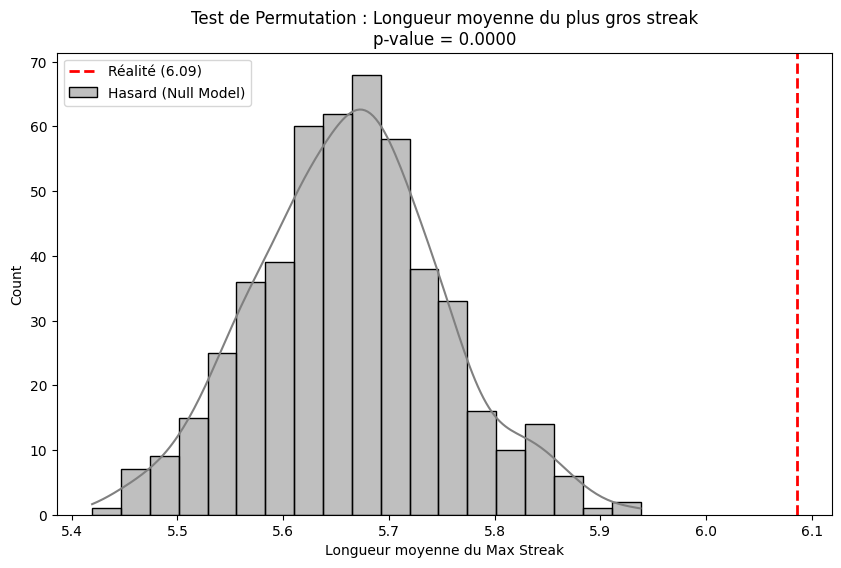

✅ CONCLUSION : Les joueurs font des séries significativement plus longues que le hasard.


In [ ]:
def calculate_max_streak(wins_series):
    """Calcule la plus longue série de victoires consécutives (1)"""
    if len(wins_series) == 0: return 0
    # Astuce vectorielle pour calculer les streaks
    change = wins_series.ne(wins_series.shift())
    counts = change.cumsum()
    # On ne garde que les victoires (1)
    streaks = wins_series.groupby(counts).sum()
    # On retourne le max (0 si que des défaites)
    return streaks.max()

# Paramètres de simulation
n_permutations = 500
results_null_model = []

print(f"Lancement de la simulation ({n_permutations} permutations)... Patience.")

# On ne prend que les joueurs avec assez de parties (>20) pour que ce soit pertinent
users_to_test = df_reg['user_id'].value_counts()
valid_users = users_to_test[users_to_test > 20].index
df_sim = df_reg[df_reg['user_id'].isin(valid_users)].copy()

real_streaks_mean = df_sim.groupby('user_id')['win'].apply(calculate_max_streak).mean()

# Simulation
simulated_means = []
for i in range(n_permutations):
    # Mélange aléatoire des résultats AU SEIN de chaque joueur
    # transform(np.random.permutation) mélange les données groupe par groupe
    shuffled_wins = df_sim.groupby('user_id')['win'].transform(np.random.permutation)
    
    # On recalcule les streaks sur ces données mélangées
    # Note: on doit reconstruire un groupby temporaire pour appliquer la fonction
    # C'est un peu lent, c'est normal
    sim_streak_avg = shuffled_wins.groupby(df_sim['user_id']).apply(calculate_max_streak).mean()
    simulated_means.append(sim_streak_avg)

# Visualisation
plt.figure(figsize=(10, 6))
sns.histplot(simulated_means, kde=True, color="gray", label="Hasard (Null Model)")
plt.axvline(real_streaks_mean, color="red", linestyle="--", linewidth=2, label=f"Réalité ({real_streaks_mean:.2f})")

# Calcul de la p-value empirique
p_val_sim = np.mean([s >= real_streaks_mean for s in simulated_means])

plt.title(f"Test de Permutation : Longueur moyenne du plus gros streak\np-value = {p_val_sim:.4f}")
plt.xlabel("Longueur moyenne du Max Streak")
plt.legend()
plt.show()

if p_val_sim < 0.05:
    print("✅ CONCLUSION : Les joueurs font des séries significativement plus longues que le hasard.")
else:
    print("❌ CONCLUSION : Les séries observées ne se distinguent pas du hasard.")